# Lab 1.1: Graph Regularization

In this lab, you will learn how to perform graph-based machine learning via regularization techniques.
The specific objectives are:

*   Implement different graph-based regularization techniques to perform node-wise signal regression.
*   Analyze the trade-off between fitting and regularization.
*   Explain the perfromance of particular regularizer.

**Completion requirements**

*   Showing the graph sparsity as a function of abstract network hyper-parameters.
*   Implementing and analyzing two regularizers for signal denosing and reconstruction. 
 



## Dataset and problem definition

To achieve the above objectives, we will work with a real-world weather dataset called **Molene**.
This dataset contains weather temperature over 32 distinct stations in France recorded for a month with hourly resolution.
We will treat each time instant as a graph signal and aim to recover it from noisy measurments and signals with missing values.
For this, we will compare two regularization techniques:
*   Tikhonov regularizer
$$
\hat{\textbf{x}} = \text{arg}\min_{\textbf{x}} \|\textbf{y} - \textbf{x}\|_2^2 + \alpha \textbf{x}^T\textbf{L}\textbf{x}
$$

*   Trend filtering.
$$
\hat{\textbf{x}} = \text{arg}\min_{\textbf{x}} \|\textbf{y} - \textbf{x}\|_2^2 + \beta \|\textbf{B}^T\textbf{x}\|_1,
$$
where $\textbf{B}$ is the indcidence matrix of the graph.

## Libraries

* Numpy
* Pandas
* PyGSP or NetwrokX (or any other viable libraries)
* Scikit-learn
* Matplotlib
* CVXPy and CVXOPT (or any other optimization solver library)

In [2]:
import numpy as np
import pandas as pd
from pygsp import graphs, plotting
import matplotlib.pyplot as plt
import cvxpy as cp
import cvxopt as cvxopt

## Building the graph

We can treat each sensor as a node of a graph and the temperatures as signals over these nodes.
These sensors have also metadata such as their geolocation.
We can therefore build an abstract network connecting them.
This network can for instance be build using these metadata or using a portion of the time series and connecting nodes based on their statistical dependencies in them (e.g. Pearson correlation).
In either case, you could use different criteria to connect the nodes such as $k$-nearest neighbors, $\epsilon$-ball graph, etc.
*It is up to you to build any graph from any data* 

### Task 1

Build a **connected** and **sparse** graph between sensors.
Choose your hyperparameters to achieve at least 80% sparsity ($\frac{\text{zeros of } \textbf{A}}{N^2}$).
If you cannot ensure a connected graph with such a sparsity factor it can also be less sparse.
Tune your hyper parameters accordingly.

In [63]:
## Reading metadata of the stations
stations_metadata = pd.read_csv('lab1_molene/weather_stations_filtered_Molene.csv',index_col=0)
# stations_metadata

NumÃ©ro                  Nom   Latitude Longitude  Lambert II X  \
0   22016001        ILE-DE-BREHAT  48Â°51'18N  3Â°00'12W         24419   
1   22092001              KERPERT  48Â°24'12N  3Â°08'48W         23925   
3   22135001             LOUARGAT  48Â°33'06N  3Â°22'36W         24101   
4   22147006           MERDRIGNAC  48Â°10'54N  2Â°24'36W         23644   
5   22168001          PLOUMANAC'H  48Â°49'30N  3Â°28'18W         24410   
6   22219003          PLOUGUENAST  48Â°15'54N  2Â°44'54W         23752   
7   22247002       POMMERIT-JAUDY  48Â°44'30N  3Â°15'00W         24306   
8   22261002            QUINTENIC  48Â°31'06N  2Â°25'12W         24018   
9   22266001            ROSTRENEN  48Â°13'48N  3Â°18'24W         23742   
10  22282001      SAINT-CAST-LE-G  48Â°38'36N  2Â°14'48W         24149   
11  22372001            ST BRIEUC  48Â°32'00N  2Â°51'06W         24055   
19  29158001      PTE DE PENMARCH  47Â°47'48N  4Â°22'24W         23324   
20  29163003    PLEYBER-CHRIST SA  48Â°30'00N  3Â°51'12W         24070   
21  29168001           PTE DU RAZ  48Â°02'18N  4Â°43'54W         23614   
25  29263002         ST-SEGAL S A  48Â°13'36N  4Â°05'48W         23783   
27  29276001          SIBIRIL S A  48Â°39'36N  4Â°04'36W         24261   
29  29278001               SPEZET  48Â°10'24N  3Â°43'42W         23701   
30  35228001               DINARD  48Â°35'18N  2Â°04'30W         24081   
31  44069002             GUERANDE  47Â°17'30N  2Â°25'48W         22657   
33  44184001     PTE DE CHEMOULIN  47Â°14'00N  2Â°17'54W         22586   
35  56007001                AURAY  47Â°39'30N  2Â°58'12W         23090   
36  56009001   BELLE ILE-LE TALUT  47Â°17'36N  3Â°13'06W         22698   
37  56017003               BIGNAN  47Â°53'00N  2Â°43'42W         23328   
38  56069001         ILE DE GROIX  47Â°39'06N  3Â°30'06W         23110   
40  56159001           PLEUCADEUC  47Â°45'54N  2Â°23'12W         23180   
41  56165003             PLOERMEL  47Â°57'00N  2Â°23'48W         23386   
43  56178003              PONTIVY  48Â°03'48N  2Â°56'42W         23537   
44  56185001  LORIENT-LANN BIHOUE  47Â°45'42N  3Â°26'06W         23229   
45  56240003           SARZEAU SA  47Â°30'42N  2Â°47'48W         22917   
46  56243001          VANNES-SENE  47Â°36'12N  2Â°42'48W         23016   
47  56251001                THEIX  47Â°38'24N  2Â°37'12W         23053   
48  85163001       NOIRMOUTIER EN  47Â°00'12N  2Â°15'24W         22330   

     Lambert II Y  Altitude  
0            2081        25  
1            1941       281  
3            1784       148  
4            2471       131  
5            1735        55  
6            2226       235  
7            1891        55  
8            2487        71  
9            1809       262  
10           2622        35  
11           2169       135  
19            977         3  
20           1428       147  
21            735        67  
25           1223        63  
27           1278        58  
29           1491       138  
30           2745        58  
31           2396         4  
33           2492        14  
35           2016        26  
36           1802        34  
37           2213       112  
38           1617        41  
40           2460        65  
41           2465        65  
43           2065        83  
44           1676        45  
45           2135        37  
46           2204         3  
47           2276        29  
48           2508         3

In [64]:
## extracting the coordinates for each station from the metadata => these coordinates can be treated as distance
coordinates_df = stations_metadata.iloc[:,-3:]  
coordinates_df = coordinates_df - coordinates_df.mean() # => Removing mean to have more tangible coordinates
coordinates = coordinates_df.to_numpy()

In [65]:
## Add your code here
## You can PyGSP or NetwrokX pakcage for this to have predefined graph builders.
from sklearn.neighbors import kneighbors_graph
k = 2
Adjacency = kneighbors_graph(coordinates, k, mode='connectivity', include_self=False)
# To make it symmetric
Adjacency = 0.5 * (Adjacency + Adjacency.T)
G = graphs.Graph(Adjacency)

def calculate_sparsity(G):
    return 1 - np.count_nonzero(G.W.toarray()) / (G.N**2)

### Question 1
What type of graph did you use and what is the hyperparameter of it?
Make a plot of the graph sparsity as a function of at least one hyper parameter.
Make sure the graph remains connected.

**Answer**:
<font color = 'red'>
I use ***k-nearest-neighbor*** graph and choose $k$ as the hyperparameter. We can see that as $k$ increases, the sparsity of the graph decreases.

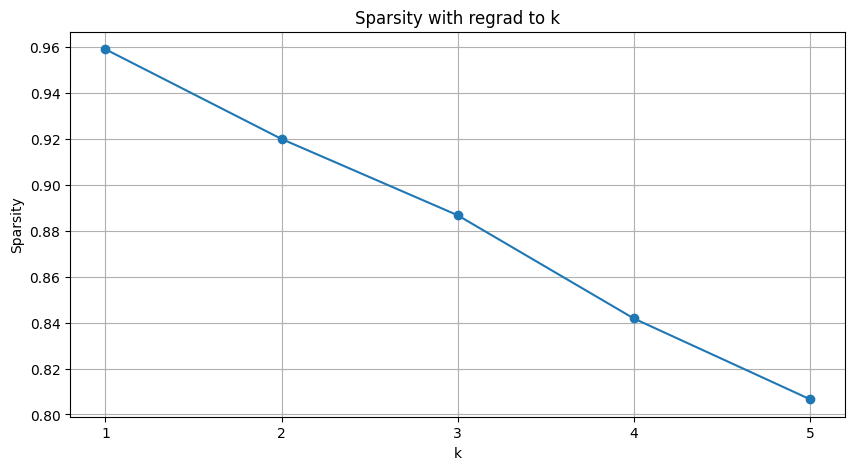

In [66]:
## Add your code here
k_values = range(1,6)
sparsity_values = []
for k in k_values:
    Adjacency = kneighbors_graph(coordinates, k, mode='connectivity', include_self=False)
    Adjacency = 0.5 * (Adjacency + Adjacency.T)
    G = graphs.Graph(Adjacency)
    sparsity_values.append(calculate_sparsity(G))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(k_values, sparsity_values, marker='o')
plt.xlabel('k')
plt.xticks(k_values)
plt.ylabel('Sparsity')
plt.title('Sparsity with regrad to k')
plt.grid(True)
plt.show()

## Noisy measurements

Let $e$ be the average energy of the graph signals in the dataset.
$$
e = \frac{1}{m} \sum_{i=1}^m \|\textbf{x}_i\|_2^2,
$$
where $m$ is the number of data points.
Generate $m$ noisy graph signal $\textbf{y} = \textbf{x} + \textbf{n}$ where $\textbf{n}$ is a zero-mean Gaussian noise $\textbf{n} \sim \mathcal{N}(0,Ïƒ^2\textbf{I})$.
Consider $\sigma^2 = e/2$.

In [67]:
## loading the data
timeseries_data = pd.read_csv('lab1_molene/filtered_data_Molene.csv', index_col = 'date', parse_dates = True)
timeseries_data = timeseries_data - timeseries_data.mean() # => removing mean from data

In [68]:
x = timeseries_data.to_numpy().transpose()  # => transpose the data so we have each column as a graph signal

e = np.sum(np.square(x))/x.shape[1] # computing average energy

sigma = e/x.shape[0]/2
n = np.random.multivariate_normal(np.zeros(x.shape[0]),sigma*np.eye(x.shape[0]),size=x.shape[1]).transpose() # => generating noise

y = x + n   # adding to noise to synthesize noisy observations

def calculate_y(sigma):
    n = np.random.multivariate_normal(np.zeros(x.shape[0]),sigma*np.eye(x.shape[0]),size=x.shape[1]).transpose() # => generating noise
    y = x + n  
    return y


### Task 2

Use the Tikhonov regularizer for a choice of $\alpha > 0$ to recover signal $\textbf{x}$ from the measurements $\textbf{y}$.
Provide the signal recovery metric root normalized mean square error (rNMSE)
$$
\text{rNMSE} = \left(\frac{\sum_{i=1}^m \|\hat{\textbf{x}}_i-\textbf{x}_i\|_2^2}{\sum_{i=1}^m\|\textbf{y}_i\|_2^2}
\right)^{0.5}
$$

In [8]:
## set the regularizer coefficient
alpha = 0.5

## exploit the graph Laplacian (if you are using pygsp, convert it to dense format from sparse for further computations(use .todense()).
L = G.L.todense()


## write down the closed form solution for Tikhonov regularizer
x_hat = np.matmul(np.linalg.inv(np.eye(L.shape[0]) + alpha * L),y) 

rnmse = np.sqrt(np.square(x_hat-x).mean())/y.std()  # rnmse definition

print(f"The rNMSE is: {np.round(rnmse,4)}")


The rNMSE is: 0.2879


### Question 2

Illustrate rNMSE as a function of $\alpha \in [0,10]$. What do you conclude about the role of the regularizer?




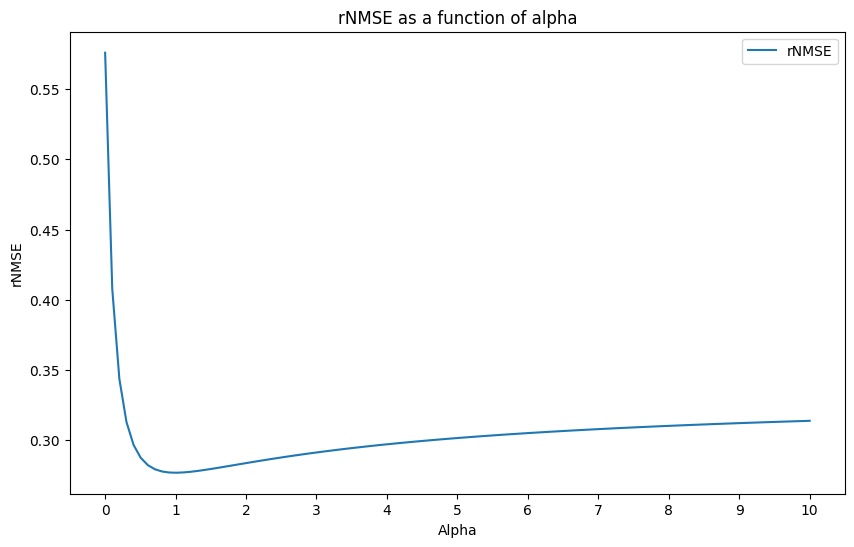

In [9]:
## Add your code here
alphas = np.linspace(0, 10, 100)
rnmse_values = []

def calculate_rnmse(y, rnmse_values):
    for alpha in alphas:
        x_hat = np.matmul(np.linalg.inv(np.eye(L.shape[0]) + alpha * L),y) 
        rnmse = np.sqrt(np.square(x_hat-x).mean())/y.std()
        rnmse_values.append(rnmse)

calculate_rnmse(y=y, rnmse_values=rnmse_values)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(alphas, rnmse_values, label='rNMSE')
plt.xlabel('Alpha')
plt.xticks(range(0,11))
plt.ylabel('rNMSE')
plt.title('rNMSE as a function of alpha')
plt.legend()
plt.show()

**Answer**:
<font color = 'red'>
The parameter $\alpha$ in the Tikhonov regularizer denotes the weight we place on the regularization term. It's noticeable in the graph that when $\alpha$ is near $0$, the rNMSE is comparatively high. However, within the range $(0.6, 0.9)$, there's a notable point where the rNMSE reaches a minimum, reflecting the optimal regularization weight. Beyond this range, as the weight on the regularizer increases, so does the rNMSE. This indicates that a proper regularization weight can enhance the model's performance, as little or zero regularization might lead to overfitting of the given measurements. Conversely, assigning excessive weight to the regularizer could make the model overly smooth, thereby increasing the error rate.

### Question 3

Consider now different noisy scenarios, $\sigma^2 = e/10$ and $\sigma^2 = e$.
Add the respective line into your plot.
What do you conclude about the role of the regularizer?

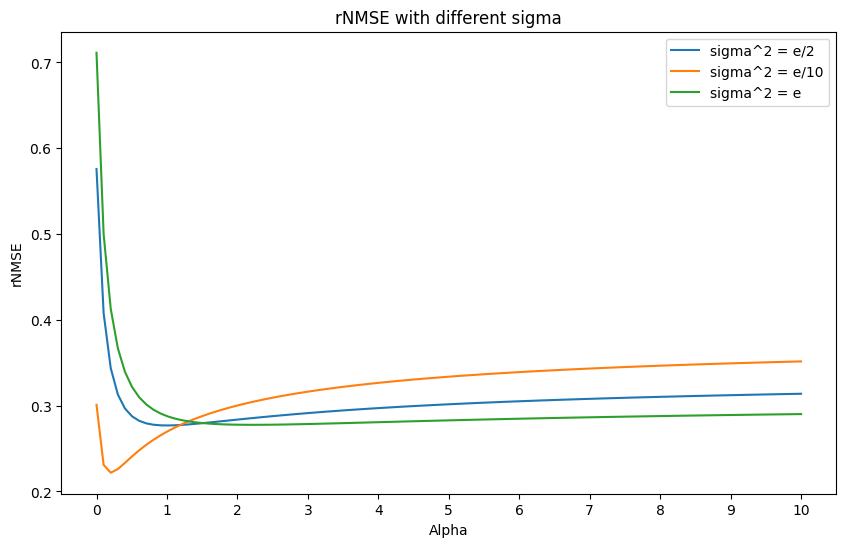

In [10]:
## Add your code here
y_10 = calculate_y(sigma=e/x.shape[0]/10)
y_1 = calculate_y(sigma=e/x.shape[0])

rnmse_10 = []
rnmse_1 = []

calculate_rnmse(y=y_10, rnmse_values=rnmse_10)
calculate_rnmse(y=y_1, rnmse_values=rnmse_1)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(alphas, rnmse_values, label='sigma^2 = e/2')
plt.plot(alphas, rnmse_10, label='sigma^2 = e/10')
plt.plot(alphas, rnmse_1, label='sigma^2 = e')
plt.xlabel('Alpha')
plt.xticks(range(0,11))
plt.ylabel('rNMSE')
plt.title('rNMSE with different sigma')
plt.legend()
plt.show()

**Answer**:
<font color = 'red'>
The parameter $\sigma$ represents the standard deviation of the noise sampled from the Gaussian distribution, with larger $\sigma$ values leading to higher noise variances. From the graph we can see that for values of $\alpha$ less than $1$, a lower $\sigma = e / 10$ results in a lower rNMSE. Interestingly, there's a point within the range $(1, 1.3)$ where all three $\sigma$ values yield the same rNMSE. Beyond this point, a pattern emerges wherein larger $\sigma$ values correlate with lower rNMSE values. We can conclude that when the regularization term is properly-weighted, higher noise levels lead to more errors in the recovery performance. When we assign too much weight to the regularizer, less noise in the measurements actually makes the data oversmooth so that the performance is worse.

### Task 3

Implement trend filtering regularizer and compare the performance with the Tikhonov regularizer for $\sigma^2 = e/2$.

<font color = 'red'>
I implement trend filtering regularizer.


In [19]:
## Add your code here.
## You may need an optimization solver if your chosen regularizer does not have a closed form solution.

import cvxpy as cp

# Constructing incidence matrix
A = G.W.todense()
B = np.zeros((G.N, G.Ne))
edge_index = 0
for i in range(G.N):
    for j in range(i+1, G.N):
        if A[i, j] > 0:  # if there is an edge
            B[i, edge_index] = G.W[i,j]
            B[j, edge_index] = -1 * G.W[i,j]
            edge_index += 1

beta = 0.5
x_tf = cp.Variable((y.shape[0], y.shape[1]))
obj = cp.Minimize(cp.sum_squares(y-x_tf)
                  + beta * cp.norm(np.matmul(B.T, x_tf), 1) )
prob = cp.Problem(obj)
prob.solve()
# x_tf.value

array([[-0.04248862, -0.42511684, -2.90589479, ...,  3.60805182,
        -0.65903697,  2.48816705],
       [-0.98020757, -0.0801674 , -0.06009199, ...,  1.20753835,
         8.36274916,  3.27389017],
       [-1.10809466, -0.39225112, -1.62919908, ...,  0.72541936,
         2.90924688,  5.38607206],
       ...,
       [ 0.45992823,  0.79655686,  1.25087054, ...,  2.35216826,
         3.42362426,  4.68822115],
       [ 3.39386816,  1.79928331,  0.22967305, ...,  3.30363233,
         3.91856987,  1.02375217],
       [-0.19399235,  0.17691857,  3.12344396, ...,  0.23971759,
         0.51456732, -2.12691042]])

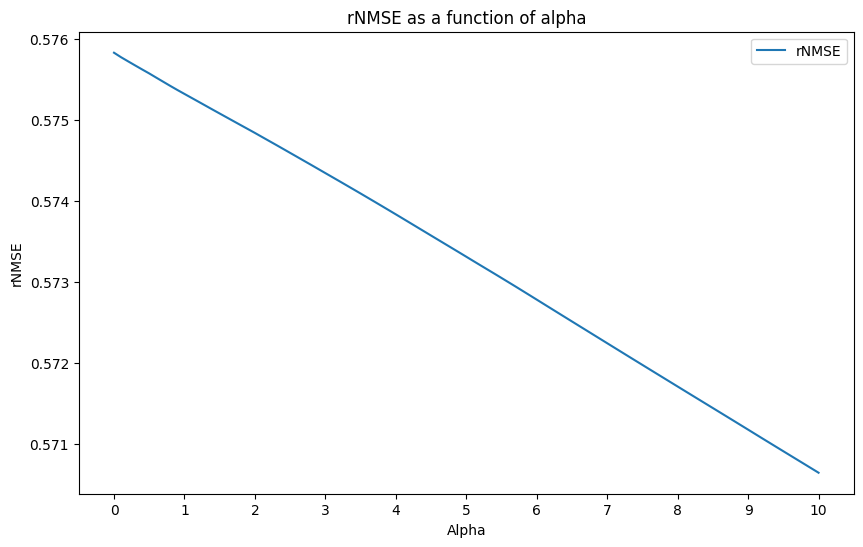

In [28]:
alphas = np.linspace(0.0, 10.0, num=101)
rnmse_values = []
def calculate_rnmse_tf(y, rnmse_values):
    for alpha in alphas:
        x_tf = cp.Variable((y.shape[0], y.shape[1]))
        obj = cp.Minimize(cp.sum_squares(y-x_tf)
                  + alpha * cp.norm(np.matmul(B.T, x_tf), 1))
        prob = cp.Problem(obj)
        prob.solve()
        x_hat = x_tf.value
        rnmse = np.sqrt(np.square(x_hat-x).mean())/y.std()
        rnmse_values.append(rnmse)

calculate_rnmse_tf(y=y, rnmse_values=rnmse_values)
# Plotting
plt.figure(figsize=(10,6))
plt.plot(alphas, rnmse_values, label='rNMSE')
plt.xlabel('Alpha')
plt.xticks(range(0,11))
plt.ylabel('rNMSE')
plt.title('rNMSE as a function of alpha')
plt.legend()
plt.show()

### Question 4

Why and when does one regularizer performs better than the other?

**Answer**:
<font color = 'red'>
The Tikhonov regularizer perform significantly better under all alphas I sample. The difference between Tikhonov regularizer and trend filtering regularizer is that Tikhonov uses the squared L2 norm while trend filtering uses L1 norm. The choice of L2 norm over L1 norm can generate lower-biased models in our task, since L1 norm encourages model sparsity by making the parameters zero or close to zero and therefore loses information. L2 norm is better in our task because it tends to distribute the weight more evenly by using all available features with more balanced coefficients, which leads to better generalization.

## Missing measurements

Consider now that the signal is noiseless but it is observed only in a portion of the nodes: $\textbf{y} = \textbf{P} \textbf{x}$, where $\textbf{P} \in \mathbb{R}^{M \times N}$ is the sampling matrix collecting $M$ out of the possible $N$ samples. 

### Task 4

Taking the best regularization weights from the above exercise, show the rNMSE of the recovered signal for both regularizers and $M = \{3,9,15,21,27\}$.

In [61]:
## add your code here
## Generate the data with missing values (or only indices).

M = [3, 9, 15, 21, 27]

# Randomly select M rows from the identity matrix
indices = np.random.choice(x.shape[0], 3, replace=False)
# indices = [0,1,2]
I = np.eye(x.shape[0])
P = np.zeros((3,32))
P[:3, :] = I[indices, :]

P_list = []
for m in M:

    indices = np.random.choice(x.shape[0], m, replace=False)
    # indices = [0,1,2]
    I = np.eye(x.shape[0])
    P = np.zeros((m,32))
    P[:m, :] = I[indices, :]
    P_list.append(P)

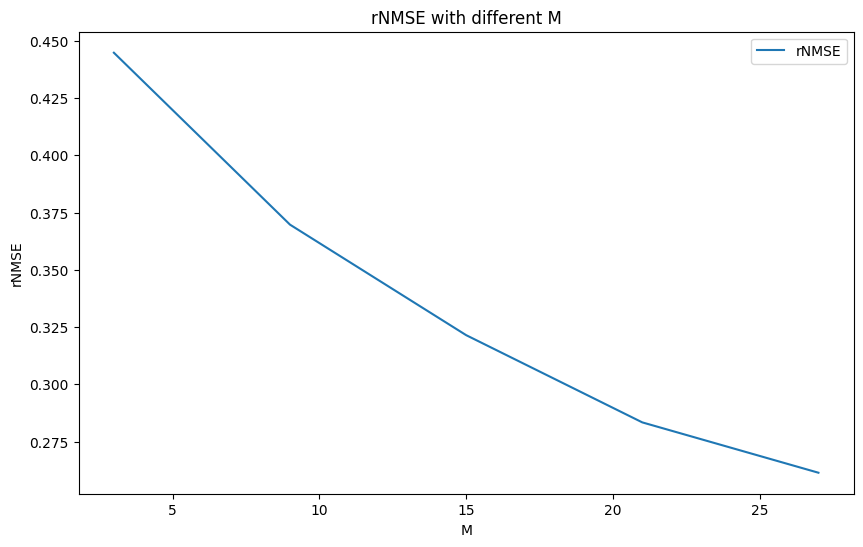

In [69]:
## Add your code here
## solve and evaluate for Tikhonov regularizer

x = timeseries_data.to_numpy().transpose()

# x_p = P @ x
# x_hat_p = np.matmul(np.linalg.inv(P.T @ P + 0.5 * L), P.T @ x_p) 
# rnmse_p = np.sqrt(np.square(x_hat_p-x).mean())/y.std()
# print(x_hat_p)

rnmse_tkp = []

for P in P_list:

    y_2 = x
    x_2 = cp.Variable((y.shape[0], y.shape[1]))
    obj = cp.Minimize(cp.sum_squares(P @ (y_2-x_2))
                    + 1 * cp.sum_squares(B.T @ x_2) )
    prob = cp.Problem(obj)
    prob.solve()
    x_hat = x_2.value
    rnmse = np.sqrt(np.square(x_hat-x).mean())/y_2.std()
    rnmse_tkp.append(rnmse)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(M, rnmse_tkp, label='rNMSE')
plt.xlabel('M')
# plt.xticks(range(0,11))
plt.ylabel('rNMSE')
plt.title('rNMSE with different M')
plt.legend()
plt.show()


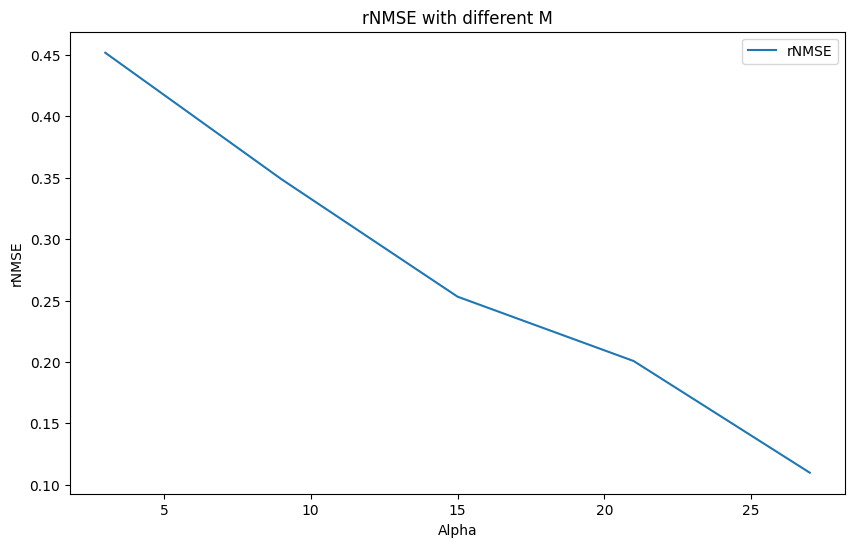

In [70]:
## Add your code here
## solve and evaluate for the trend filtering regularizer

rnmse_tfp = []

for P in P_list:
    y_2 = x
    x_tf_p = cp.Variable((y.shape[0], y.shape[1]))
    obj = cp.Minimize(cp.sum_squares(P @ (y_2-x_tf_p))
                    + 1 * cp.norm(np.matmul(B.T, x_tf_p), 1) )
    prob = cp.Problem(obj)
    prob.solve()
    x_hat = x_tf_p.value
    rnmse = np.sqrt(np.square(x_hat-x).mean())/y_2.std()
    rnmse_tfp.append(rnmse)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(M, rnmse_tfp, label='rNMSE')
plt.xlabel('Alpha')
# plt.xticks(range(0,11))
plt.ylabel('rNMSE')
plt.title('rNMSE with different M')
plt.legend()
plt.show()

### Question 5
 What would you conclude about the behaviour of the two regularizers?

**Answer**:
<font color = 'red'>
Tikhonov regularizer's performance is expected. As the observation becomes more comprehensive, the model generates less error, and the error rate when $M=27$ in the noiseless environment is close to the lowest error rate when there is noise. However, while trend filtering regularizer also has better performance with more observations, the error rate is significanly lower than both its own performance with noised observations and Tikhonov regualrizer with noiseless obervations. This suggests that trend filtering regularizer is far more sensitive to noise than Tikhonov regularizer, and if the environment is noiseless, trend filtering regularizer becomes the better choice.

# Lab 1.2: Node Embedding, Node Classification, and Link Prediction

**Objectives:** 
- Implement different traditional and embedding-based graph representation learning methods
- Compare and analyse the performances of the methods for embedding learning, node classification and link prediction tasks. 

**Completion requirements:**

By the end of this notebook, you should have:
- Implemented all code cells for:
  - the representation learning methods. 
  - training the methods.
  - assesing the performance of the methods.
- Answered the analysis questions on each section. 

## Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:

- TDC
- Numpy
- Pytorch
- NetworkX
- Matplotlib
- Scikit-learn
- Pytorch geometric  

Run the following code to import the packages

In [1]:
# import the libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import mask as Mask
from torch_geometric.utils import to_networkx
from torch_geometric.nn.models import Node2Vec
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

# import the datasets
from tdc.multi_pred import PPI
from torch_geometric.datasets import Planetoid

---

## Lab 1.2.1: Generate and visualize the node embeddings

### Decription of the dataset:    
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. More infos about Cora dataset can be found here: https://paperswithcode.com/dataset/cora.

Run the following code to load the cora dataset:

In [3]:
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

Run the following code to check the characteristics of the dataset:

In [4]:
# number of nodes, dimensions of features, number of edges
print(data.x.shape[0])
print(data.x.shape[1])
print(data.edge_index.shape[1])

2708
1433
10556


### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

  **(a) Generate hand crafted features** by concatenating the
  
      - 1. Degree centrality 
      - 2. clustering coefficient 
      - 3. betweenness centrality 
      
     as feature vector for each node and visulaize it using TSNE.

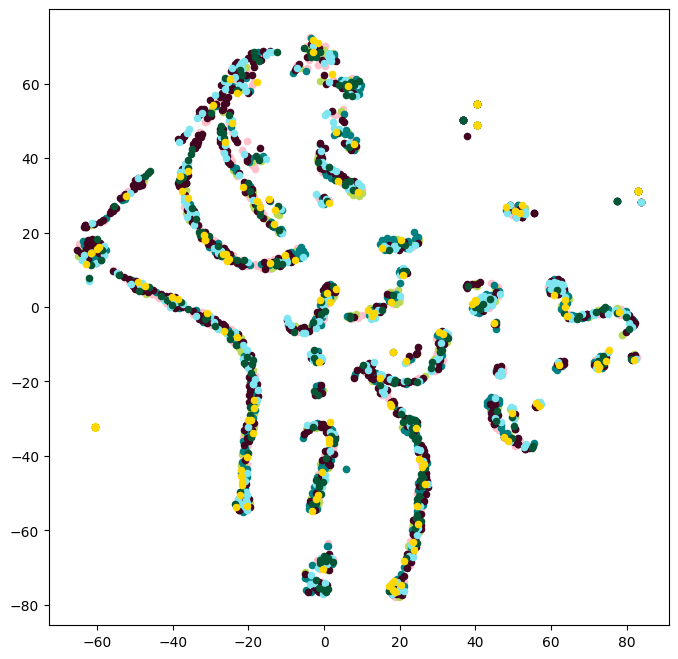

In [5]:
# The package networkx has the corresponding function

# write code here to convert the pytorch graph to networkx graph
G = to_networkx(data, to_undirected=True)

# call the corresponding functions to calculate the hand crafted features
degree_centrality = nx.degree_centrality(G)
clustering_coefficient = nx.clustering(G)
betweenness_centrality = nx.betweenness_centrality(G)
features = []
for node in G.nodes:
    features.append([degree_centrality[node], clustering_coefficient[node], betweenness_centrality[node]])

#visualize features
features = torch.tensor(features)
features_embedded = TSNE(n_components=2).fit_transform(features)
y = data.y.cpu().numpy()
colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plt.figure(figsize=(8, 8))
for i in range(cora_dataset.num_classes):
    plt.scatter(features_embedded[y == i, 0], features_embedded[y == i, 1], s=20, color=colors[i])
# plt.axis('off')
plt.show()

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(b) Generate features vectors from Node2Vec using the following parameters. The output features should have three dimensions. Visulaize it using TSNE.**


    The size of each embedding vector.
    - embedding_dim=3
    
    The walk length
    - walk_length=20
    
    The actual context size which is considered for positive samples. 
    This parameter increases the effective sampling rate by reusing samples across different source nodes.
    - context_size=10
    
    The number of walks to sample for each node
    - walks_per_node=10
    
    The number of negative samples to use for each positive sample
    - num_negative_samples=1
    
    Likelihood of immediately revisiting a node in the walk
    - p=1
    
    Control parameter to interpolate between breadth-first strategy and depth-first strategy
    - q=1
    
    If set to :obj:`True`, gradients w.r.t. to the weight matrix will be sparse
    - sparse=False 
    
    batch size
    - batch_size=128
    
    shuffle the input data
    - shuffle=True
    
    number of epochs in training
    - train epochs=200
    
    learning rate in training
    - learning rate=0.01

In [6]:
# The Node2Vec model is imported above from torch_geometric.nn.models
from torch_geometric.data import DataLoader
# from torch_geometric.nn import Node2Vec
from torch.optim import Adam

# # Define your Node2Vec model here

model = Node2Vec(edge_index=data.edge_index, embedding_dim=3, walk_length=20, context_size=10, walks_per_node=10, p=1, q=1, num_negative_samples=1, sparse=False)

device = torch.device('cpu')
model = model.to(device)
data = data.to(device)

# Define a loader here
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)


# define an optimizer here
optimizer = Adam(model.parameters(), lr=0.01)

#define the training function for the Node2Vec model here
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

#define the test function for the Node2Vec model here
def test():
    model.eval()
    with torch.no_grad():
        z = model()
        acc = model.test(z[data.train_mask], data.y[data.train_mask],
                         z[data.test_mask], data.y[data.test_mask],
                         max_iter=150)
        return acc

In [7]:
######################################################################### 
# train your Node2Vec model
for epoch in range(200):
    loss = train()
    # print(f'Epoch: {epoch+1}, Loss: {loss}')
#########################################################################

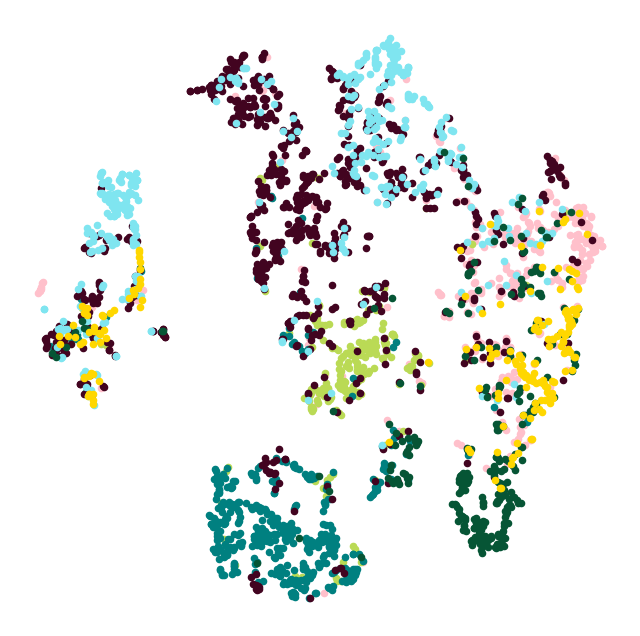

In [8]:
######################################################################### 
# produce embedding using the trained model

with torch.no_grad():
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))

z_plt = TSNE(n_components=2).fit_transform(z.cpu().numpy())
y = data.y.cpu().numpy()

# visualize the features here

colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plt.figure(figsize=(8, 8))
for i in range(cora_dataset.num_classes):
    plt.scatter(z_plt[y == i, 0], z_plt[y == i, 1], s=20, color=colors[i])
plt.axis('off')
plt.show()

######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(c)Compare the features generated from above. From the visualization, which feature vector is more informative? And give the reasons in the following cell:**

**Answer here:** The feature vector generated by Node2Vec is significantly better than hand-crafted feature vector. It is notable that our dataset is relatively complex and using only three properties of nodes might be too naive for the classification task. In contrast, Node2Vec considers both local and global information by taking random walks and is capable of learning more complex, high-dimensional features.

---

## Lab 1.2.2: Node Classification

### â›” Problem definition 

Node Classification is a machine learning task in graph-based data analysis, where the goal is to assign labels to nodes in a graph based on the properties of nodes and the relationships between them.

Node Classification models aim to predict non-existing node properties (known as the target property) based on other node properties. Model performance can be measured using benchmark datasets like Cora, Citeseer, and Pubmed, among others, typically using Accuracy and F1. In this exercise, we use accuracy.

The dataset needs to be split for the node classification task, and the performance of the model is measured by its accuracy on the test set. Cora has the built in split. We will use its default split in this exercise.

(a)Use the hand-crafted features as input, perform node classification using a 2-layer Multi-Layer Perceptron(MLP). 

The hyperparameters for the MLP should be as follows: 

    - the input dimensions are same as the dimensions of input features
    - hidden unit dimension is set to be 16
    - output dimensions should be the number of classes to predict
    - use relu as activate function 
    - train the MLP for 200 epochs

Which loss would you use for training the MLP? Answer in the following cell:

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**Answer here:**  I use cross entropy loss as it is a good and widely-used loss function for classification problems.

In the following cell, define a two layer MLP using the parameters given above:

In [9]:
######################################################################### 
# define a two layer MLP

class MLP(nn.Module):
    def __init__(self, input_dim=cora_dataset.num_node_features, output_dim=cora_dataset.num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

#########################################################################   

In the following cell, train your MLP for 200 epochs and print the training loss, accuracy on the test set for each epoch:

In [10]:
data.y[data.train_mask]
cora_dataset.num_node_features

1433

In [28]:
######################################################################### 
# instantiate your MLP model here
model_hc = MLP(input_dim=features.shape[1]).to(device)
features = features.to(device)
######################################################################### 


######################################################################### 
# define a training function
test_acc_list = []
def train_feature(model=model_hc, features=features, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        acc = test_mlp()
        test_acc_list.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4}, Acc: {acc}')

######################################################################### 

######################################################################### 
# define a test function
def test_mlp(model=model_hc,features=features):
    model.eval()
    _, pred = model(features).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    # print('Accuracy: {:.4f}'.format(acc))
    return acc

######################################################################### 

######################################################################### 
#train your model here and print the accuracy
train_feature(features=features)
test_mlp()
######################################################################### 

Epoch: 0, Loss: 1.977, Acc: 0.103
Epoch: 1, Loss: 1.969, Acc: 0.103
Epoch: 2, Loss: 1.962, Acc: 0.103
Epoch: 3, Loss: 1.957, Acc: 0.103
Epoch: 4, Loss: 1.952, Acc: 0.103
Epoch: 5, Loss: 1.948, Acc: 0.103
Epoch: 6, Loss: 1.945, Acc: 0.098
Epoch: 7, Loss: 1.942, Acc: 0.1
Epoch: 8, Loss: 1.94, Acc: 0.096
Epoch: 9, Loss: 1.938, Acc: 0.096
Epoch: 10, Loss: 1.936, Acc: 0.112
Epoch: 11, Loss: 1.934, Acc: 0.124
Epoch: 12, Loss: 1.933, Acc: 0.103
Epoch: 13, Loss: 1.932, Acc: 0.108
Epoch: 14, Loss: 1.93, Acc: 0.107
Epoch: 15, Loss: 1.929, Acc: 0.108
Epoch: 16, Loss: 1.928, Acc: 0.125
Epoch: 17, Loss: 1.927, Acc: 0.124
Epoch: 18, Loss: 1.926, Acc: 0.131
Epoch: 19, Loss: 1.925, Acc: 0.132
Epoch: 20, Loss: 1.924, Acc: 0.132
Epoch: 21, Loss: 1.923, Acc: 0.14
Epoch: 22, Loss: 1.922, Acc: 0.14
Epoch: 23, Loss: 1.921, Acc: 0.142
Epoch: 24, Loss: 1.92, Acc: 0.142
Epoch: 25, Loss: 1.919, Acc: 0.136
Epoch: 26, Loss: 1.919, Acc: 0.13
Epoch: 27, Loss: 1.918, Acc: 0.134
Epoch: 28, Loss: 1.918, Acc: 0.111
Epo

0.11

In the following cell, visualize the accuracy on the test set in each epoch:

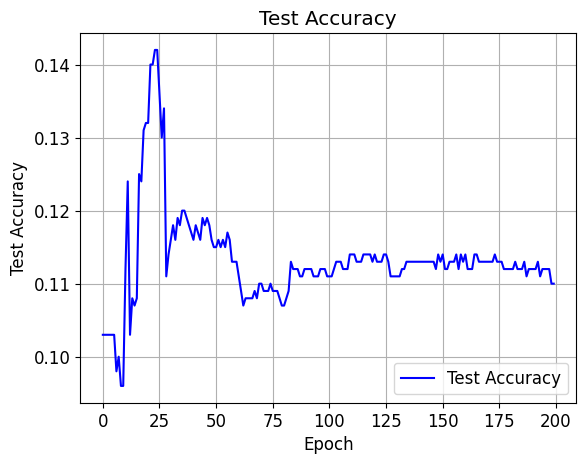

In [29]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs
# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label="Test Accuracy")

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(b)Repeat the node classification task using features generated from Node2Vec above

In [34]:
######################################################################### 
# instantiate another MLP with the same parameters
# MLP node using node2vec emb
model_n2v = MLP(input_dim=z.shape[1])

######################################################################### 

######################################################################### 
#get the features generated from the Node2Vec trained above
features_em = z
######################################################################### 

######################################################################### 
#train function for MLP
test_acc_list = []
def train_n2v(model=model_n2v, features=features_em, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        acc = test_n2v()
        test_acc_list.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4}, Acc: {acc}')
######################################################################### 

######################################################################### 
# test function for your MLP
def test_n2v(model=model_n2v,features=features_em):
    model.eval()
    _, pred = model(features).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(acc))
    return acc
######################################################################### 

In [35]:
######################################################################### 
# train your model here:
train_n2v(features=features_em)
test_n2v()
######################################################################### 

Accuracy: 0.1910
Epoch: 0, Loss: 1.897, Acc: 0.191
Accuracy: 0.2140
Epoch: 1, Loss: 1.857, Acc: 0.214
Accuracy: 0.2380
Epoch: 2, Loss: 1.819, Acc: 0.238
Accuracy: 0.2630
Epoch: 3, Loss: 1.782, Acc: 0.263
Accuracy: 0.3050
Epoch: 4, Loss: 1.746, Acc: 0.305
Accuracy: 0.4420
Epoch: 5, Loss: 1.71, Acc: 0.442
Accuracy: 0.4980
Epoch: 6, Loss: 1.676, Acc: 0.498
Accuracy: 0.5240
Epoch: 7, Loss: 1.642, Acc: 0.524
Accuracy: 0.5720
Epoch: 8, Loss: 1.608, Acc: 0.572
Accuracy: 0.5930
Epoch: 9, Loss: 1.575, Acc: 0.593
Accuracy: 0.6230
Epoch: 10, Loss: 1.543, Acc: 0.623
Accuracy: 0.6390
Epoch: 11, Loss: 1.511, Acc: 0.639
Accuracy: 0.6380
Epoch: 12, Loss: 1.48, Acc: 0.638
Accuracy: 0.6320
Epoch: 13, Loss: 1.45, Acc: 0.632
Accuracy: 0.6320
Epoch: 14, Loss: 1.42, Acc: 0.632
Accuracy: 0.6310
Epoch: 15, Loss: 1.392, Acc: 0.631
Accuracy: 0.6310
Epoch: 16, Loss: 1.364, Acc: 0.631
Accuracy: 0.6310
Epoch: 17, Loss: 1.338, Acc: 0.631
Accuracy: 0.6280
Epoch: 18, Loss: 1.312, Acc: 0.628
Accuracy: 0.6280
Epoch: 19

0.594

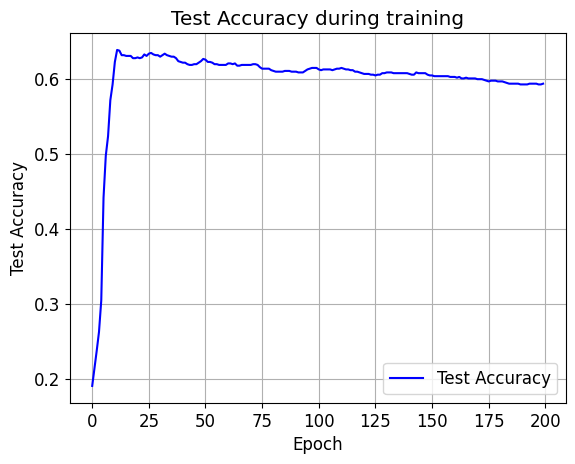

In [36]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(c)Repeat the node classification task using original features from Cora dataset

In [37]:
######################################################################### 
# instantiate another MLP with the same parameters
# MLP node using cora features

model_cora = MLP(input_dim=cora_dataset.num_features).to(device)

######################################################################### 

######################################################################### 
#define a train function for your model
test_acc_list = []
def train_cora(model=model_cora, features=cora_dataset.x, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        acc = test_cora()
        test_acc_list.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4}, Acc: {acc}')

######################################################################### 

######################################################################### 
#define a test function to your model

def test_cora(model=model_cora,features=cora_dataset.x):
    model.eval()
    _, pred = model(features).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(acc))
    return acc

######################################################################### 

In [38]:
######################################################################### 
# train your model
train_cora(features=cora_dataset.x)
test_cora()
######################################################################### 

Accuracy: 0.1590
Epoch: 0, Loss: 1.958, Acc: 0.159
Accuracy: 0.1970
Epoch: 1, Loss: 1.874, Acc: 0.197
Accuracy: 0.2520
Epoch: 2, Loss: 1.767, Acc: 0.252
Accuracy: 0.3430
Epoch: 3, Loss: 1.632, Acc: 0.343
Accuracy: 0.4010
Epoch: 4, Loss: 1.48, Acc: 0.401
Accuracy: 0.4270
Epoch: 5, Loss: 1.32, Acc: 0.427
Accuracy: 0.4580
Epoch: 6, Loss: 1.156, Acc: 0.458
Accuracy: 0.4640
Epoch: 7, Loss: 0.9975, Acc: 0.464
Accuracy: 0.4730
Epoch: 8, Loss: 0.8489, Acc: 0.473
Accuracy: 0.4770
Epoch: 9, Loss: 0.7143, Acc: 0.477
Accuracy: 0.4860
Epoch: 10, Loss: 0.5966, Acc: 0.486
Accuracy: 0.4900
Epoch: 11, Loss: 0.4961, Acc: 0.49
Accuracy: 0.4970
Epoch: 12, Loss: 0.4118, Acc: 0.497
Accuracy: 0.5090
Epoch: 13, Loss: 0.342, Acc: 0.509
Accuracy: 0.5130
Epoch: 14, Loss: 0.2842, Acc: 0.513
Accuracy: 0.5120
Epoch: 15, Loss: 0.2367, Acc: 0.512
Accuracy: 0.5170
Epoch: 16, Loss: 0.1976, Acc: 0.517
Accuracy: 0.5200
Epoch: 17, Loss: 0.1656, Acc: 0.52
Accuracy: 0.5180
Epoch: 18, Loss: 0.1394, Acc: 0.518
Accuracy: 0.522

0.555

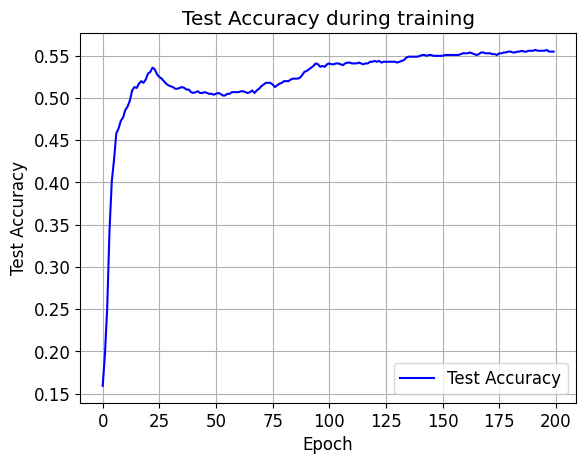

In [39]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(d)Run label propagation algorithm on Cora for 10 iterations. Specifically use the row normailized adjancency matrix as the transition matrix. You can pad the label vectors for the test nodes using zero padding as initialization.

In [115]:
######################################################################### 
# one-hot encode the true label for training data
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
import networkx as nx
import scipy.sparse as sp

# Get the labels of the training data
train_mask = data.train_mask
train_labels = data.y[train_mask]

# One-hot encode the labels
labels = np.zeros((data.num_nodes, cora_dataset.num_classes))
######################################################################### 

######################################################################### 
# mask the val and test labels
labels[train_mask] = F.one_hot(data.y[train_mask], cora_dataset.num_classes)
#########################################################################

######################################################################### 
# transition matrix as adj matrix

G = to_networkx(data, to_undirected=True)
A = nx.adjacency_matrix(G)

# row normalization

row_sum = np.sum(A, axis=1)
row_sum_reshaped = np.reshape(row_sum, (A.shape[0], 1))
A_norm = A / row_sum_reshaped
# A_norm = A_norm.toarray()
######################################################################### 

######################################################################### 
# write code here to run the label propagation algorithm for 10 epochs

epochs = range(10)
y_labels = labels
for e in epochs:
    y_labels = A_norm @ y_labels

prop_labels = np.zeros(y_labels.shape[0])
for i in range(y_labels.shape[0]):
    prop_labels[i] = np.argmax(y_labels[i])
######################################################################### 

In [116]:
test_labels = data.y[data.test_mask]
acc = int(np.sum(prop_labels[data.test_mask] == data.y.numpy()[data.test_mask])) / int(data.test_mask.sum())
print(f'Accuracy: {acc}')

Accuracy: 0.691


### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(e)(1)Which method perform the best? Give the answer in the following cell:

Answer: Label propagation performs the best in our dataset, with the accuracy of 0.691.

(e)(2)What do you conclude about the informativeness of the extracted node feature? Give the answer in the following cell:

Answer: The model trained with Node2Vec features have better accuracy to the model trained with original cora dataset features. It is noteworthy that the dimension of Node2Vec feature vectors is only 3, while the dimension of the original cora features is over 1000. Therefore, we can conclude that the generalization capability of Node2Vec vectors are incredibly good, as it uses far less vector space to achieve higher accuracies.

(e)(3)Is there any particular method or embedding quality you would like to comment? Give the answer in the following cell

Answer: To my surprise, the label propagation algorithm actually gives the best performance. This suggests that while label propagation might be a simple algorithm, it can be extremely effective under certain circumstances. We can use it as a benchmark for node classification problems we encounter in the future as it is quite easy to implement and offers considerably sufficient information about the data. 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(f)Increase the training set to 80% using one random division and run the above experiments again using hand-crafted features, Node2Vec generated features, original cora features, and label propagation algorithm. Run the code in the following cell to generate a random split.

In [40]:
num_nodes = data.x.shape[0]
node_ids = [i for i in range(num_nodes)]

# split the nodes into train-val-test: 80-10-10
ids_train, ids_val_test = train_test_split(node_ids, test_size=0.2, random_state=42)
ids_val, ids_test = train_test_split(ids_val_test, test_size=0.5, random_state=41)
train_mask = Mask.index_to_mask(torch.Tensor(ids_train).long(), size=num_nodes)
val_mask = Mask.index_to_mask(torch.Tensor(ids_val).long(), size=num_nodes)
test_mask = Mask.index_to_mask(torch.Tensor(ids_test).long(), size=num_nodes)

In [43]:
######################################################################### 
# add your code here to run the experiment using hand-crafted features

G = to_networkx(data, to_undirected=True)
degree_centrality = nx.degree_centrality(G)
clustering_coefficient = nx.clustering(G)
betweenness_centrality = nx.betweenness_centrality(G)
features = []
for node in G.nodes:
    features.append([degree_centrality[node], clustering_coefficient[node], betweenness_centrality[node]])
features = torch.tensor(features)
model_hc = MLP(input_dim=features.shape[1]).to(device)
features = features.to(device)

test_acc_list = []
def train_feature(model=model_hc, features=features, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        acc = test_mlp()
        test_acc_list.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4}, Acc: {acc}')

def test_mlp(model=model_hc,features=features):
    model.eval()
    _, pred = model(features).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(acc))
    return acc

train_feature(features=features)
test_mlp()
######################################################################### 

Accuracy: 0.0910
Epoch: 0, Loss: 1.967, Acc: 0.091
Accuracy: 0.0970
Epoch: 1, Loss: 1.959, Acc: 0.097
Accuracy: 0.1050
Epoch: 2, Loss: 1.952, Acc: 0.105
Accuracy: 0.1050
Epoch: 3, Loss: 1.946, Acc: 0.105
Accuracy: 0.1050
Epoch: 4, Loss: 1.942, Acc: 0.105
Accuracy: 0.1140
Epoch: 5, Loss: 1.938, Acc: 0.114
Accuracy: 0.1230
Epoch: 6, Loss: 1.936, Acc: 0.123
Accuracy: 0.1430
Epoch: 7, Loss: 1.934, Acc: 0.143
Accuracy: 0.2250
Epoch: 8, Loss: 1.932, Acc: 0.225
Accuracy: 0.2110
Epoch: 9, Loss: 1.931, Acc: 0.211
Accuracy: 0.0640
Epoch: 10, Loss: 1.931, Acc: 0.064
Accuracy: 0.0650
Epoch: 11, Loss: 1.93, Acc: 0.065
Accuracy: 0.1000
Epoch: 12, Loss: 1.929, Acc: 0.1
Accuracy: 0.1070
Epoch: 13, Loss: 1.929, Acc: 0.107
Accuracy: 0.1070
Epoch: 14, Loss: 1.928, Acc: 0.107
Accuracy: 0.1070
Epoch: 15, Loss: 1.927, Acc: 0.107
Accuracy: 0.1110
Epoch: 16, Loss: 1.926, Acc: 0.111
Accuracy: 0.1110
Epoch: 17, Loss: 1.925, Acc: 0.111
Accuracy: 0.1120
Epoch: 18, Loss: 1.924, Acc: 0.112
Accuracy: 0.1120
Epoch: 1

0.114

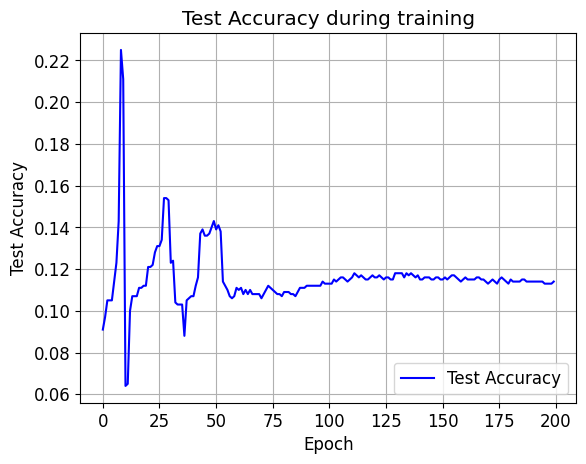

In [44]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs
    
# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

In [45]:
######################################################################### 
# add your code here to run the experiment using Node2Vec features
# MLP node using node2vec emb

model_n2v = MLP(input_dim=z.shape[1])
features_em = z

test_acc_list = []

def train_n2v(model=model_n2v, features=features_em, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        acc = test_n2v()
        test_acc_list.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4}, Acc: {acc}')

def test_n2v(model=model_n2v,features=features_em):
    model.eval()
    _, pred = model(features).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(acc))
    return acc       

train_n2v(features=features_em)
acc = test_n2v() 
######################################################################### 

Accuracy: 0.0790
Epoch: 0, Loss: 1.97, Acc: 0.079
Accuracy: 0.0870
Epoch: 1, Loss: 1.947, Acc: 0.087
Accuracy: 0.0940
Epoch: 2, Loss: 1.926, Acc: 0.094
Accuracy: 0.1250
Epoch: 3, Loss: 1.904, Acc: 0.125
Accuracy: 0.1570
Epoch: 4, Loss: 1.884, Acc: 0.157
Accuracy: 0.1980
Epoch: 5, Loss: 1.863, Acc: 0.198
Accuracy: 0.2200
Epoch: 6, Loss: 1.843, Acc: 0.22
Accuracy: 0.2400
Epoch: 7, Loss: 1.823, Acc: 0.24
Accuracy: 0.2530
Epoch: 8, Loss: 1.802, Acc: 0.253
Accuracy: 0.2590
Epoch: 9, Loss: 1.782, Acc: 0.259
Accuracy: 0.2640
Epoch: 10, Loss: 1.762, Acc: 0.264
Accuracy: 0.2740
Epoch: 11, Loss: 1.741, Acc: 0.274
Accuracy: 0.2840
Epoch: 12, Loss: 1.721, Acc: 0.284
Accuracy: 0.2920
Epoch: 13, Loss: 1.7, Acc: 0.292
Accuracy: 0.3070
Epoch: 14, Loss: 1.679, Acc: 0.307
Accuracy: 0.3200
Epoch: 15, Loss: 1.658, Acc: 0.32
Accuracy: 0.3400
Epoch: 16, Loss: 1.636, Acc: 0.34
Accuracy: 0.3480
Epoch: 17, Loss: 1.614, Acc: 0.348
Accuracy: 0.3570
Epoch: 18, Loss: 1.592, Acc: 0.357
Accuracy: 0.3630
Epoch: 19, L

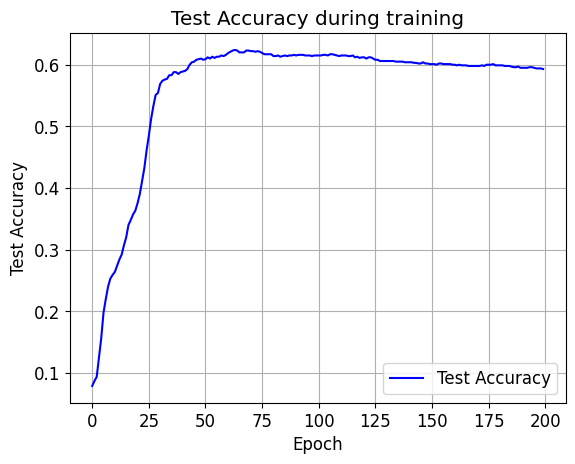

In [46]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

In [47]:
######################################################################### 
# add your code here to run the experiment using original cora features
model_cora = MLP(input_dim=cora_dataset.num_features).to(device)

test_acc_list = []

def train_cora(model=model_cora, features=cora_dataset.x, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        acc = test_cora()
        test_acc_list.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4}, Acc: {acc}')

def test_cora(model=model_cora,features=cora_dataset.x):
    model.eval()
    _, pred = model(features).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(acc))
    return acc

train_cora(features=cora_dataset.x)
acc = test_cora()
######################################################################### 

Accuracy: 0.1440
Epoch: 0, Loss: 1.948, Acc: 0.144
Accuracy: 0.2340
Epoch: 1, Loss: 1.857, Acc: 0.234
Accuracy: 0.3060
Epoch: 2, Loss: 1.745, Acc: 0.306
Accuracy: 0.3260
Epoch: 3, Loss: 1.61, Acc: 0.326
Accuracy: 0.3500
Epoch: 4, Loss: 1.462, Acc: 0.35
Accuracy: 0.3700
Epoch: 5, Loss: 1.312, Acc: 0.37
Accuracy: 0.3930
Epoch: 6, Loss: 1.164, Acc: 0.393
Accuracy: 0.4140
Epoch: 7, Loss: 1.022, Acc: 0.414
Accuracy: 0.4380
Epoch: 8, Loss: 0.8906, Acc: 0.438
Accuracy: 0.4440
Epoch: 9, Loss: 0.7693, Acc: 0.444
Accuracy: 0.4510
Epoch: 10, Loss: 0.6592, Acc: 0.451
Accuracy: 0.4590
Epoch: 11, Loss: 0.5606, Acc: 0.459
Accuracy: 0.4660
Epoch: 12, Loss: 0.4726, Acc: 0.466
Accuracy: 0.4780
Epoch: 13, Loss: 0.3955, Acc: 0.478
Accuracy: 0.4830
Epoch: 14, Loss: 0.3293, Acc: 0.483
Accuracy: 0.4840
Epoch: 15, Loss: 0.2734, Acc: 0.484
Accuracy: 0.4930
Epoch: 16, Loss: 0.2272, Acc: 0.493
Accuracy: 0.4900
Epoch: 17, Loss: 0.19, Acc: 0.49
Accuracy: 0.4880
Epoch: 18, Loss: 0.16, Acc: 0.488
Accuracy: 0.4960
Ep

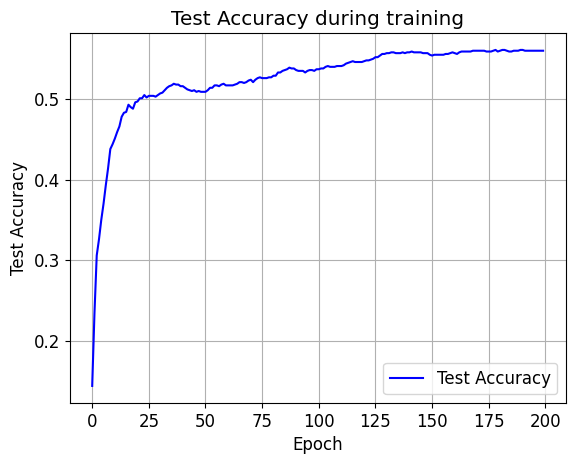

In [48]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

In [112]:
######################################################################### 
# add your code here to run the label propagation

train_labels = data.y[train_mask]

labels = np.zeros((data.num_nodes, cora_dataset.num_classes))
labels[train_mask] = F.one_hot(data.y[train_mask], cora_dataset.num_classes)
G = to_networkx(data, to_undirected=True)
A = nx.adjacency_matrix(G)
row_sum = np.sum(A, axis=1)
row_sum_reshaped = np.reshape(row_sum, (A.shape[0], 1))
A_norm = A / row_sum_reshaped
epochs = range(10)
y_labels = labels
for e in epochs:
    y_labels = A_norm @ y_labels

prop_labels = np.zeros(y_labels.shape[0])
for i in range(y_labels.shape[0]):
    prop_labels[i] = np.argmax(y_labels[i])

######################################################################### 

In [114]:
test_labels = data.y[data.test_mask]
acc = int(np.sum(prop_labels[data.test_mask] == data.y.numpy()[data.test_mask])) / int(data.test_mask.sum())
print(f'Accuracy: {acc}')

accuracy: 0.855


### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(g)Compare the performance of different methods. Which method is affected most by the increase in training set size? Explain the possible reasons behind your observation in the following cell:

Answer: Label propagation is affected the most by the increase in the training set size. The increase in the training set size makes 80% of the nodes already of the ground-truth label before the propagation even begins, which means that the accruacy can only be higher than 80% once the propagation begins. And since label propagation is a well-performed method in the previous experiement, the accuracy keeps on incraesing by 5.5%.

---

## Lab 1.2.3 Link Prediction

### ðŸ“š Decription of the dataset:    

Protein-protein interactions (PPI) are very important to discover new putative therapeutic targets to cure disease. Expensive and time-consuming wet-lab results are usually required to obtain PPI activity. PPI prediction aims to predict the PPI activity given a pair of proteins' amino acid sequences. For the Protein-protein interaction dataset, we build up the network as follows:

    - Each protein is a node on an undirected graph G. 
    - There is a connection between the two nodes if there is a known interaction in the training data.
    - The link prediction problem in this case is defined as: given the two nodes on the undirected graph, predict whether there is a link between them.

More information about the used PPI dataset can be found here: https://tdcommons.ai/multi_pred_tasks/ppi/

Use 70% of the data as training data, 30% as test data. Run the following code to load and split the cora dataset:

In [50]:
ppi = 'HuRI'
ppi_data = PPI(name=ppi)
# negative sample using fraction=1
ppi_data.neg_sample(frac=1)
# This would return a pytorch-geometric graph
graph = ppi_data.to_graph(format='pyg', split=True, seed=42)
graph_pyg = graph['pyg_graph']
# common neighbors
num_nodes = graph_pyg.x.shape[0]
n_id = range(num_nodes)
# split the data using
split = ppi_data.get_split(method = 'random', seed = 42, frac = [0.7, 0.0, 0.3])

Found local copy...
Loading...
Done!


Run the following code to check the test set

In [49]:
# split["test"]

As the positive and negative edges in the split are noted with the name of the proteins, run the following code to convert the positive and negative edges with the proteins name to the edges with their indices.

In [51]:
# convert the edges split into graph_pyg
map_book = graph["index_to_entities"]

train_edge_0 = split["train"]["Protein1_ID"].tolist()
train_edge_0_id = map(lambda key: map_book[key], train_edge_0)
train_edge_0 = [i for i in train_edge_0_id]

train_edge_1 = split["train"]["Protein2_ID"].tolist()
train_edge_1_id = map(lambda key: map_book[key], train_edge_1)
train_edge_1 = [i for i in train_edge_1_id]

train_edges = torch.vstack((torch.tensor(train_edge_0),torch.tensor(train_edge_1)))


test_edge_0 = split["test"]["Protein1_ID"].tolist()
test_edge_0_id = map(lambda key: map_book[key], test_edge_0)
test_edge_0 = [i for i in test_edge_0_id]

test_edge_1 = split["test"]["Protein2_ID"].tolist()
test_edge_1_id = map(lambda key: map_book[key], test_edge_1)
test_edge_1 = [i for i in test_edge_1_id]

test_edges = torch.vstack((torch.tensor(test_edge_0),torch.tensor(test_edge_1)))


### ðŸ“š Decription of the Metrics:    

We use Average precision(AP) and Compute Area Under the Receiver Operating Characteristic Curve(AUROC) to evaluate the performance of the models in the link prediction task. The link to the descriptions of the metric can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(a)For any pair of nodes (u,v) in the test set, compute scores for the link based on the common neighbors of the node pair normalized by the sigmoid function. Plot the ROC curve and the precision recall curve.

In [119]:
######################################################################### 
#add your code here to calculate the common neighbors of the node pairs in the test set
from torch_geometric.utils import to_undirected, to_dense_adj
from scipy.special import expit

graph_e = to_networkx(graph_pyg).to_undirected()

A = to_dense_adj(to_undirected(graph_pyg.edge_index)).squeeze()

common_neighbors = torch.mm(A.T, A)
scores = expit(common_neighbors)

scores = common_neighbors[test_edges[0], test_edges[1]].numpy()
scores

#normalize the number of common neighbors using the sigmoid function
scores = common_neighbors[test_edges[0], test_edges[1]].numpy()
scores_norm = 1 / (1 + np.exp(-scores))
test_labels = split["test"].Y
######################################################################### 

In [120]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(test_labels, scores_norm)
roc_auc = auc(fpr, tpr)

# Likewise, you can use the precision_recall_curve function to compute the precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, scores_norm)

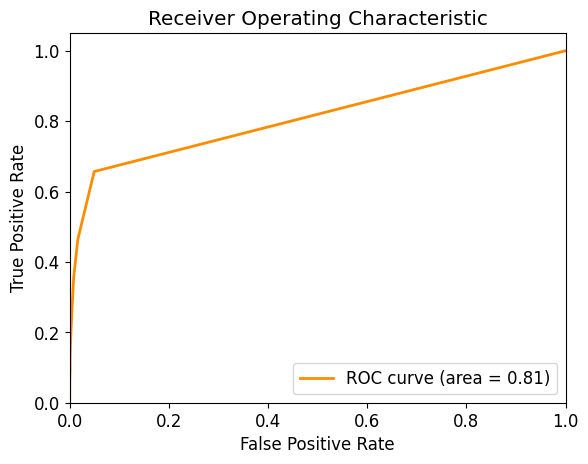

In [121]:
######################################################################### 
#add your code here to plot the ROC curve and precision recall curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
######################################################################### 

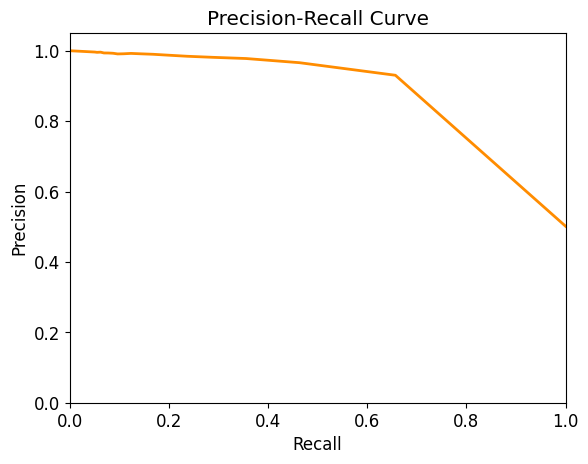

In [122]:
######################################################################### 
#add your code here to plot the precision recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(b)Extract node features using Node2Vec. Parameters stay the same as in the previous experiment. Compute cosine similarity between the extracted embedding vectors of nodes u and v in the test set as the link score. Convert the similarities into a probability distribution by applying the sigmoid function. Plot the ROC curve and the precision recall curve. 

In [52]:
######################################################################### 
# add your code here to generate embeddings for the PPI dataset using Node2Vec
device = 'cpu'
model = Node2Vec(edge_index=graph_pyg.edge_index, embedding_dim=3, walk_length=20, context_size=10, walks_per_node=10, p=1, q=1, num_negative_samples=1, sparse=False)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)
model.train()
for epoch in range(200):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss / len(loader)}")

# Step 2: Get embeddings for each node
model.eval()
with torch.no_grad():
    z = model()
# z
######################################################################### 

Epoch: 0, Loss: 1.1860728593973013
Epoch: 1, Loss: 1.006124693613786
Epoch: 2, Loss: 0.9336029703800495
Epoch: 3, Loss: 0.8943708273080679
Epoch: 4, Loss: 0.869599094757667
Epoch: 5, Loss: 0.8518976890123807
Epoch: 6, Loss: 0.8402619251838097
Epoch: 7, Loss: 0.8314850788850051
Epoch: 8, Loss: 0.8250081410774818
Epoch: 9, Loss: 0.8209041824707618
Epoch: 10, Loss: 0.8174798277708201
Epoch: 11, Loss: 0.815126475921044
Epoch: 12, Loss: 0.8130693270609929
Epoch: 13, Loss: 0.8118586411842933
Epoch: 14, Loss: 0.8107128656827487
Epoch: 15, Loss: 0.8092932902849638
Epoch: 16, Loss: 0.8082796188501211
Epoch: 17, Loss: 0.8074741519414461
Epoch: 18, Loss: 0.8068555877758906
Epoch: 19, Loss: 0.8056106723271883
Epoch: 20, Loss: 0.8056348598920382
Epoch: 21, Loss: 0.8048826107612023
Epoch: 22, Loss: 0.8041924623342661
Epoch: 23, Loss: 0.8039196307842548
Epoch: 24, Loss: 0.8030539008287283
Epoch: 25, Loss: 0.8028208805964543
Epoch: 26, Loss: 0.8024593261572031
Epoch: 27, Loss: 0.8024049474642827
Epoch

In [64]:
######################################################################### 
# add your code here to calculate the cosine similairity of the node pairs in the test set
# dont forget to normalize the similarities using sigmoid
from sklearn.metrics.pairwise import cosine_similarity

test_scores = []
for edge in test_edges.T:
    emb1 = z[edge[0]].cpu().detach().numpy().reshape(1, -1)
    emb2 = z[edge[1]].cpu().detach().numpy().reshape(1, -1)
    cosine_sim = cosine_similarity(emb1, emb2)[0][0]
    test_scores.append(cosine_sim)


######################################################################### 

In [68]:
fpr, tpr, _ = roc_curve(test_labels, test_scores)
roc_auc = auc(fpr, tpr)

# Likewise, you can use the precision_recall_curve function to compute the precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_scores)

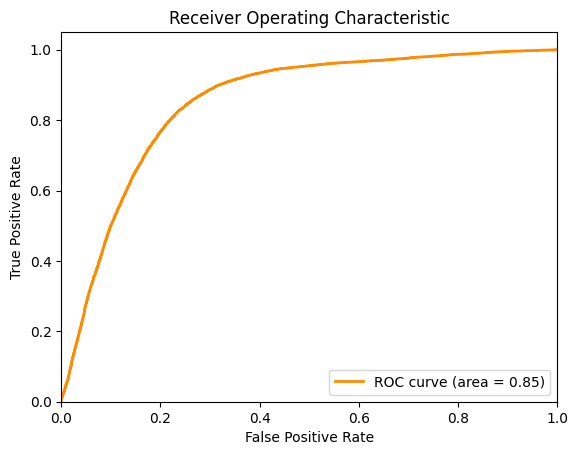

In [70]:
######################################################################### 
# add your code here to plot the roc curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
######################################################################### 

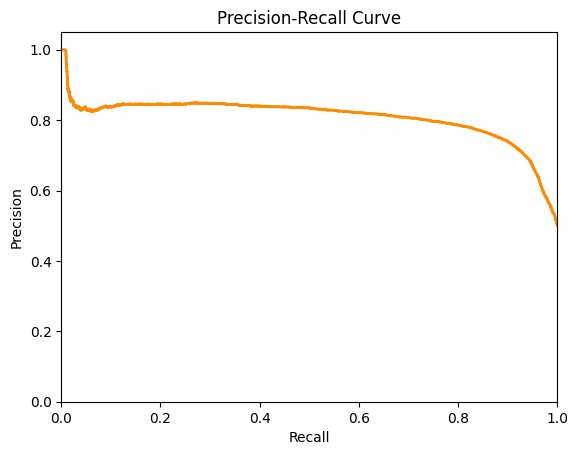

In [69]:
######################################################################### 
# add your code here to plot the precision and recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(c)Which method performs better: Node2Vec or common neighbors? Give your answer and expalain the reasons in the folowing cell.

Answer: Node2Vec performs better. The precision, recall, and the true positvie rate of Node2Vec are significantly better than common neighbors. This once again demonstrates the effectiveness of Node2Vec features. Apart from the fact that Node2Vec is able to capture more complex information in the graph, we can also see in the graph that common neighbors has a noticable turning point, which suggests that there is a threshold of the number of common neighbors.

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(d)So far we have not used the negative edges of the train set during training. Instead of directly computing scores from extracted features we will now train a two layer multilayer perceptron for predicting a link between two nodes. For any pair of nodes (u,v),  concatenate the Node2Vec extracted embedding vectors of nodes u and v. The concatenated pair serve as input to the MLP. The output layer will be two neurons predicting the probability of existence of a link. Set the hidden layer dimension to 16. 

In order to do the link prediction task, we need to prepare the data. Run the code in the following cell to concatenate the embeddings of the node pair and the true labels of the link.

In [72]:
# prepare data for link prediction task
emb_n2v = z
train_emb = []
for e in torch.transpose(train_edges, 0, 1):
    emb1 = emb_n2v[e[0]]
    emb2 = emb_n2v[e[1]]
    edge_emb = torch.hstack((emb1, emb2))
    train_emb.append(edge_emb)
train_emb = torch.stack(train_emb)

test_emb = []
for e in torch.transpose(test_edges, 0, 1):
    emb1 = emb_n2v[e[0]]
    emb2 = emb_n2v[e[1]]
    edge_emb = torch.hstack((emb1, emb2))
    test_emb.append(edge_emb)
test_emb = torch.stack(test_emb)

train_y = torch.tensor(split["train"]["Y"])
test_y = torch.tensor(split["test"]["Y"])

In the following cell, instantiate a two layer MLP and train it using the training data prepared in the previous cell. Print and visulaize the ap score and the auroc score as a function to the epochs

In [99]:
######################################################################### 
#define and train your MLP here. print the scores during training
from sklearn.metrics import average_precision_score, roc_auc_score

class MLP(nn.Module):
    def __init__(self, input_dim=6, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
model = MLP()

ap_scores = []
auroc_scores = []

def compute_metrics(true_labels, predictions):
    ap_score = average_precision_score(true_labels, predictions)
    auroc_score = roc_auc_score(true_labels, predictions)
    return ap_score, auroc_score

def train_em(model=model, features=train_emb, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out, train_y)
        loss.backward()
        optimizer.step()
        # result = torch.argmax(out, dim=1)
        ap, auroc = compute_metrics(torch.argmax(out, dim=1), train_y)
        print(f'Epoch: {epoch}, Loss: {loss} AP: {ap}, AUROC: {auroc}')
        ap_scores.append(ap)
        auroc_scores.append(auroc)

train_em()

#########################################################################     

Epoch: 0, Loss: 0.704831063747406 AP: 0.28998362714936865, AUROC: 0.45813479878205904
Epoch: 1, Loss: 0.6971114277839661 AP: 0.23674524287459206, AUROC: 0.47006041957812456
Epoch: 2, Loss: 0.6898860335350037 AP: 0.25206603735738337, AUROC: 0.4970424104963121
Epoch: 3, Loss: 0.6829790472984314 AP: 0.2943321441625907, AUROC: 0.5415555102015053
Epoch: 4, Loss: 0.6763161420822144 AP: 0.37733965174838496, AUROC: 0.5975156578025081
Epoch: 5, Loss: 0.6697931289672852 AP: 0.49802496501257043, AUROC: 0.6641228854203853
Epoch: 6, Loss: 0.6633502244949341 AP: 0.6537725342722294, AUROC: 0.7248676127577101
Epoch: 7, Loss: 0.6569400429725647 AP: 0.8034053848908397, AUROC: 0.7625392161168753
Epoch: 8, Loss: 0.6505129933357239 AP: 0.8452364596955771, AUROC: 0.7569615872637769
Epoch: 9, Loss: 0.644035279750824 AP: 0.8520557867014906, AUROC: 0.7502137663887262
Epoch: 10, Loss: 0.6374862790107727 AP: 0.8517431462393552, AUROC: 0.750357002518922
Epoch: 11, Loss: 0.6308470964431763 AP: 0.8501361326770749, 

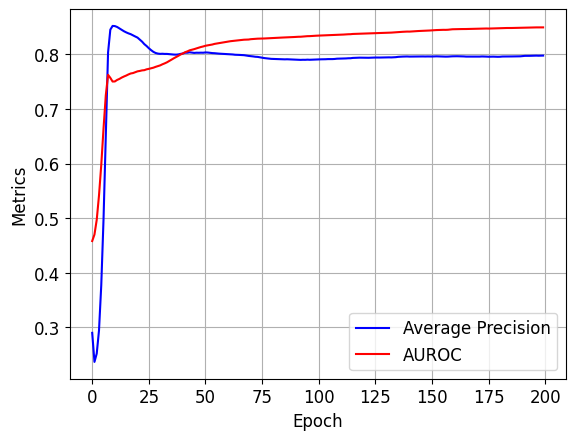

In [101]:
######################################################################### 
# visualize the scores as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(ap_scores, 'b-', label='Average Precision')
ax.plot(auroc_scores, 'r-', label='AUROC')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(e)Now increase the fraction of negative edges in the train/val/test sets to 2. Run the MLP experiment again.

Run the following code to increase fraction of the negative edges and prepare the data again

In [104]:
graph_pyg.num_nodes

8248

In [121]:
ppi = 'HuRI'
ppi_data = PPI(name=ppi)
ppi_data.neg_sample(frac=2)
# This would return a pytorch-geometric graph
graph = ppi_data.to_graph(format='pyg', split=True, seed=42)
graph_pyg = graph['pyg_graph']
# common neighbors
num_nodes = graph_pyg.x.shape[0]
n_id = range(num_nodes)

split = ppi_data.get_split(method = 'random', seed = 42, frac = [0.7, 0.0, 0.3])

# convert the edges split into graph_pyg
map_book = graph["index_to_entities"]

train_edge_0 = split["train"]["Protein1_ID"].tolist()
train_edge_0_id = map(lambda key: map_book[key], train_edge_0)
train_edge_0 = [i for i in train_edge_0_id]

train_edge_1 = split["train"]["Protein2_ID"].tolist()
train_edge_1_id = map(lambda key: map_book[key], train_edge_1)
train_edge_1 = [i for i in train_edge_1_id]

train_edges = torch.vstack((torch.tensor(train_edge_0),torch.tensor(train_edge_1)))


test_edge_0 = split["test"]["Protein1_ID"].tolist()
test_edge_0_id = map(lambda key: map_book[key], test_edge_0)
test_edge_0 = [i for i in test_edge_0_id]

test_edge_1 = split["test"]["Protein2_ID"].tolist()
test_edge_1_id = map(lambda key: map_book[key], test_edge_1)
test_edge_1 = [i for i in test_edge_1_id]

test_edges = torch.vstack((torch.tensor(test_edge_0),torch.tensor(test_edge_1)))

# prepare data 
model.eval()
emb_n2v = model(torch.arange(graph_pyg.num_nodes))
emb_n2v = emb_n2v.detach()
train_emb = []
for e in torch.transpose(train_edges, 0, 1):
    emb1 = emb_n2v[e[0]]
    emb2 = emb_n2v[e[1]]
    edge_emb = torch.hstack((emb1, emb2))
    train_emb.append(edge_emb)
train_emb = torch.stack(train_emb)

test_emb = []
for e in torch.transpose(test_edges, 0, 1):
    emb1 = emb_n2v[e[0]]
    emb2 = emb_n2v[e[1]]
    edge_emb = torch.hstack((emb1, emb2))
    test_emb.append(edge_emb)
test_emb = torch.stack(test_emb)

train_y = torch.tensor(split["train"]["Y"])
test_y = torch.tensor(split["test"]["Y"])

Found local copy...
Loading...
Done!


In [109]:
test_y.shape

torch.Size([47132])

In [122]:
######################################################################### 
#define and train your MLP here. print the scores during training

class MLP(nn.Module):
    def __init__(self, input_dim=6, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
model = MLP()

ap_scores = []
auroc_scores = []

def compute_metrics(true_labels, predictions):
    ap_score = average_precision_score(true_labels, predictions)
    auroc_score = roc_auc_score(true_labels, predictions)
    return ap_score, auroc_score

def train_em(model=model, features=train_emb, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out, train_y)
        loss.backward()
        optimizer.step()
        # result = torch.argmax(out, dim=1)
        ap, auroc = compute_metrics(torch.argmax(out, dim=1), train_y)
        print(f'Epoch: {epoch}, Loss: {loss} AP: {ap}, AUROC: {auroc}')
        ap_scores.append(ap)
        auroc_scores.append(auroc)

train_em()

Epoch: 0, Loss: 0.6330425143241882 AP: 0.04442954646818781, AUROC: 0.633662231222547
Epoch: 1, Loss: 0.6212116479873657 AP: 0.04033932566482786, AUROC: 0.7462118881962875
Epoch: 2, Loss: 0.6116006374359131 AP: 0.041309116227290034, AUROC: 0.7468503999700707
Epoch: 3, Loss: 0.6031745076179504 AP: 0.04509003888937598, AUROC: 0.737473645192379
Epoch: 4, Loss: 0.5953906178474426 AP: 0.05272769435780044, AUROC: 0.7316133243429424
Epoch: 5, Loss: 0.5879946947097778 AP: 0.06418918995183415, AUROC: 0.7336719758243107
Epoch: 6, Loss: 0.5808862447738647 AP: 0.07644290592774881, AUROC: 0.7341831480731609
Epoch: 7, Loss: 0.5740599036216736 AP: 0.09751930431958375, AUROC: 0.7403899617076508
Epoch: 8, Loss: 0.5675451159477234 AP: 0.12202669523496501, AUROC: 0.7470523024371764
Epoch: 9, Loss: 0.5613701939582825 AP: 0.142185363432256, AUROC: 0.7489020342718858
Epoch: 10, Loss: 0.5555506944656372 AP: 0.16258212588523482, AUROC: 0.7494648905621235
Epoch: 11, Loss: 0.550076425075531 AP: 0.186508639375810

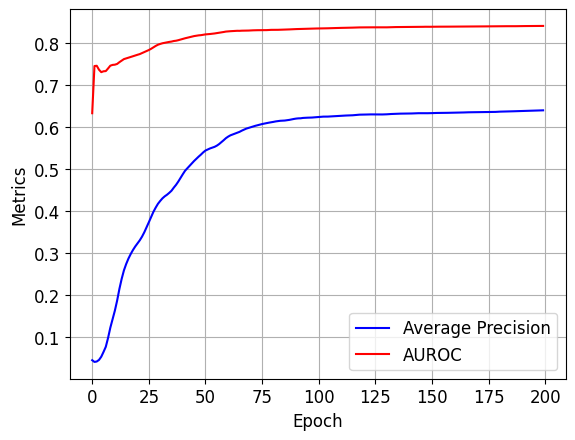

In [123]:
######################################################################### 
# visualize the scores as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(ap_scores, 'b-', label='Average Precision')
ax.plot(auroc_scores, 'r-', label='AUROC')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

### ðŸ•µ <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

(f)Which evaluation metrics is affected most by the imbalance in the size of the positive and the negative class? Which metrics would you then prefer to use in such an imbalanced setting and why?

Answer here: The average precision is affected most by the imbalance in the size of positive and negative class. I prefer using average precision in an imbalanced setting as it is more sensitive to the imblance, and focues on the successful prediction on the positive class more. 

---